# Exploratory Analysis
---

## 1. Imports

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
from wordcloud import WordCloud
from sklearn.utils import resample

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter

## 2. Load Dataset

In [171]:
email_df = pd.read_feather("./data/2_clean_email_dataset.feather")
email_df

,Email Text,Email Type,Cleaned Email Text
1,"gary , production from the high island larger ...",ham,gary production high island larger block comme...
2,- calpine daily gas nomination 1 . doc,ham,calpine daily gas nomination doc
3,fyi - see note below - already done .\nstella\...,ham,fyi see note already done stella forwarded ste...
4,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,fyi forwarded lauri allen hou ect pm kimberly ...
5,"jackie ,\nsince the inlet to 3 river plant is ...",ham,jackie since inlet river plant shut last day f...
...,...,...,...
52360,\nRick Moen a Ã©crit:> > I'm confused. I thou...,ham,rick moen im confused thought gpled money paid...
52361,date a lonely housewife always wanted to date ...,phish,date lonely housewife always wanted date lonel...
52362,request submitted : access request for anita ....,ham,request submitted access request anita dupont ...
52363,"re : important - prc mtg hi dorn & john , as y...",ham,important prc mtg hi dorn john discovered rece...


## 3. Statistics
Get ham, spam, and phish row count after cleanup.

In [172]:
email_df["Email Type"].value_counts()

Email Type
ham      27617
spam     17171
phish     6977
Name: count, dtype: int64

Most data is legitimate (ham), so the model may overfit to it. Sampling balance is needed

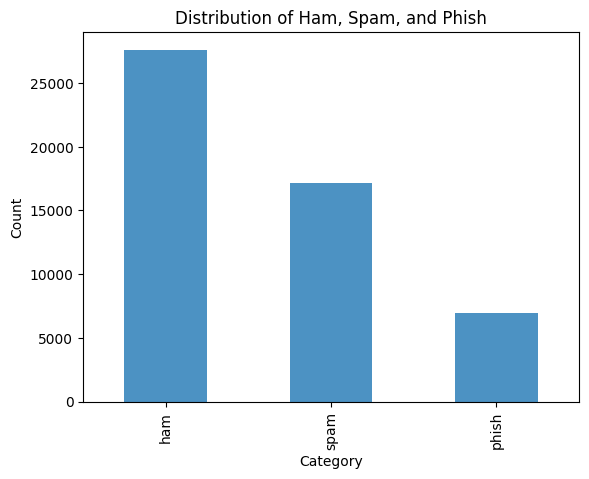

In [173]:
email_df["Email Type"].value_counts().plot(kind='bar', alpha=0.8)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Ham, Spam, and Phish')
plt.show()

We must undersample `ham` and oversample `phish` up to the median of the classes, that being the count of spam emails.

In [174]:
balanced_df = email_df.copy(deep=True)
balanced_df.drop(columns=["Email Text"], inplace=True)
balanced_df.rename(columns={"Cleaned Email Text": "Email Text"}, inplace=True)

# Get class counts
class_counts = balanced_df['Email Type'].value_counts()
print(class_counts)

# Define target count for majority class after undersampling
# For example, take the median count to not reduce too much
target_majority_count = int(class_counts.median())

# Separate by class
dfs = {}
for cls in balanced_df['Email Type'].unique():
    dfs[cls] = balanced_df[balanced_df['Email Type'] == cls]

# Undersample majority class
majority_class = class_counts.idxmax()
dfs[majority_class] = resample(
    dfs[majority_class],
    replace=False,
    n_samples=target_majority_count,
    random_state=42
)

# Oversample minority classes to reach target_majority_count
for cls, df in dfs.items():
    if cls != majority_class:
        dfs[cls] = resample(
            df,
            replace=True,
            n_samples=target_majority_count,
            random_state=42
        )

# Combine back into a single dataframe
balanced_df = pd.concat(list(dfs.values()))

# Shuffle
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
balanced_df['Email Type'].value_counts()


Email Type
ham      27617
spam     17171
phish     6977
Name: count, dtype: int64


Email Type
ham      17171
phish    17171
spam     17171
Name: count, dtype: int64

In [175]:
balanced_df

,Email Type,Email Text
0,ham,mg intergration clearly large number people ne...
1,ham,word live rock linguist mass medium case misse...
2,phish,dear user cyberage dating club contacting beha...
3,phish,personal letter personal letter franck b kwame...
4,ham,ray mm louise refers slide sum sched c sched l...
...,...,...
51508,ham,agree eileen ponton david avila lsp enserch u ...
51509,phish,mother n paln helio bro pain v c ne om gg pl o...
51510,phish,m software title available download opt email ...
51511,ham,lim mimic excel add user within enron past wee...


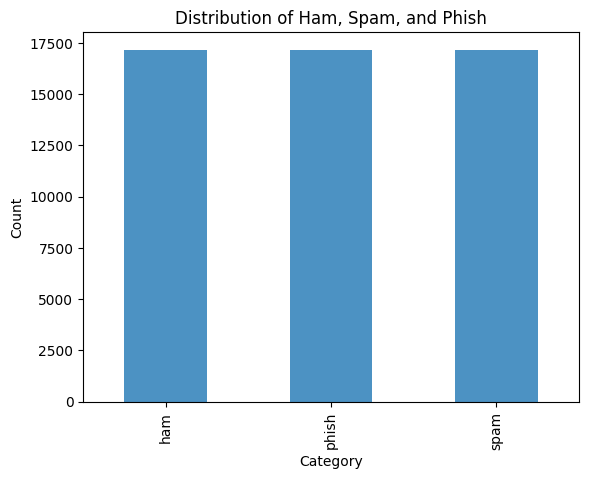

In [176]:
balanced_df["Email Type"].value_counts().plot(kind='bar', alpha=0.8)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Ham, Spam, and Phish')
plt.show()

Export as balanced dataframe to a feather file for later use with the SVM model.

In [177]:
balanced_df.to_feather("./data/2_balanced_email_dataset.feather")

### Text Characteristics of Original Email Data
Get the text characteristics before the data was cleaned via the column `"Email Text"`.

In [146]:
# Clean punctuation except for periods, question marks, and exclamation points to get sentences.
orig_email_df = email_df.copy(deep=True)

# Text length metrics
orig_email_df["char_count"] = orig_email_df["Email Text"].str.len()
orig_email_df["word_count"] = orig_email_df["Email Text"].apply(word_tokenize).apply(len)
orig_email_df["sentence_count"] = orig_email_df["Email Text"].apply(sent_tokenize).apply(len)

# # Count URLs
url_pattern = r"http[s]?://\S+|www\.\S+"
orig_email_df["url_count"] = orig_email_df["Email Text"].apply(
    lambda x: len(re.findall(url_pattern, x))
)

# Count special characters
orig_email_df["special_chars"] = orig_email_df["Email Text"].apply(
    lambda x: sum(not c.isalnum() and not c.isspace() for c in x)
)

In [154]:
orig_email_df[["char_count", "word_count", "sentence_count", "url_count", "special_chars"]].describe()

,char_count,word_count,sentence_count,url_count,special_chars
count,5.176500e+04,5.176500e+04,51765.000000,51765.000000,5.176500e+04
mean,2.052634e+03,4.362998e+02,24.011475,0.262687,1.269127e+02
std,7.499507e+04,1.594618e+04,982.524038,13.857506,5.290388e+03
min,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,5.760000e+02,1.220000e+02,7.000000,0.000000,1.800000e+01
50%,8.820000e+02,1.860000e+02,10.000000,0.000000,6.500000e+01
75%,1.674000e+03,3.550000e+02,17.000000,0.000000,1.320000e+02
max,1.703669e+07,3.623496e+06,223247.000000,3133.000000,1.202645e+06


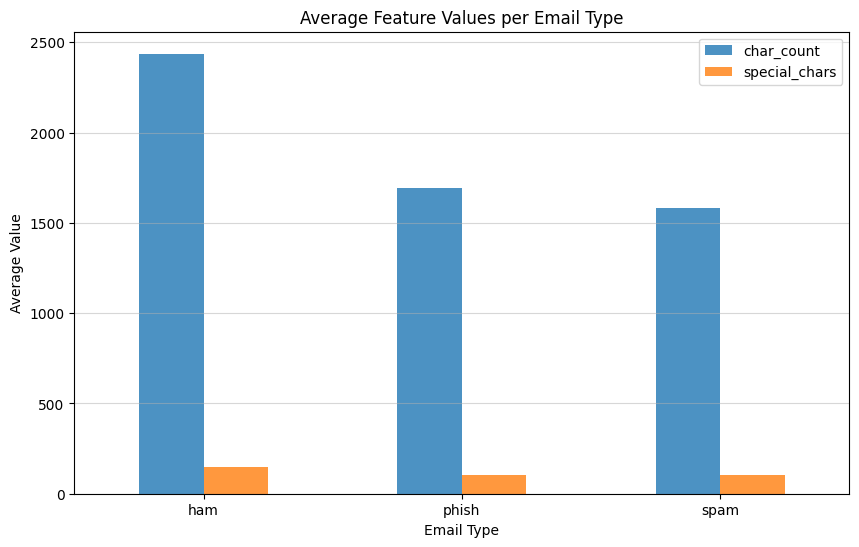

In [156]:
feature_cols = ["char_count", "special_chars"]
grouped = orig_email_df.groupby("Email Type")[feature_cols].mean()

grouped.plot(kind="bar", figsize=(10,6), alpha=0.8)
plt.title("Average Feature Values per Email Type")
plt.xlabel("Email Type")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.5)
plt.show()

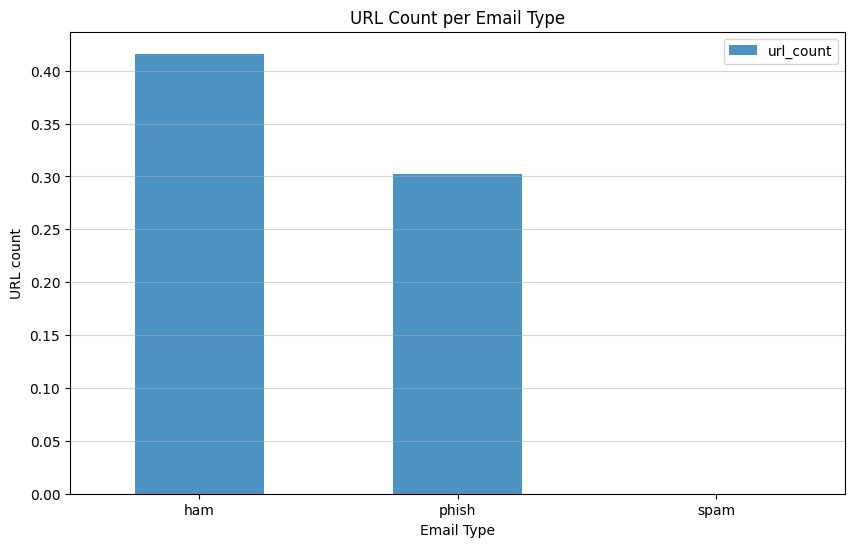

In [164]:
feature_cols = ["url_count"]
grouped = orig_email_df.groupby("Email Type")[feature_cols].mean()

grouped.plot(kind="bar", figsize=(10,6), alpha=0.8)
plt.title("URL Count per Email Type")
plt.xlabel("Email Type")
plt.ylabel("URL count")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.5)
plt.show()

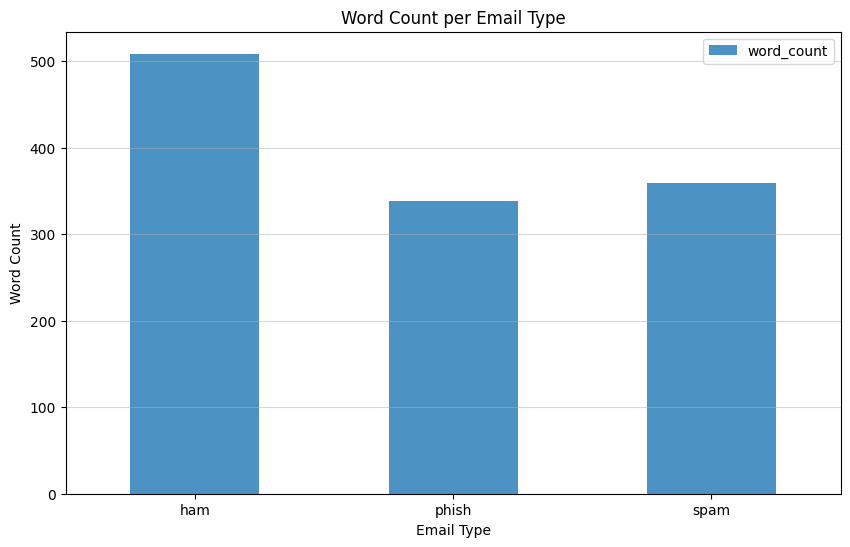

In [163]:
feature_cols = ["word_count"]
grouped = orig_email_df.groupby("Email Type")[feature_cols].mean()

grouped.plot(kind="bar", figsize=(10,6), alpha=0.8)
plt.title("Word Count per Email Type")
plt.xlabel("Email Type")
plt.ylabel("Word Count")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.5)
plt.show()

Sentence count between ham, phish, and spam.

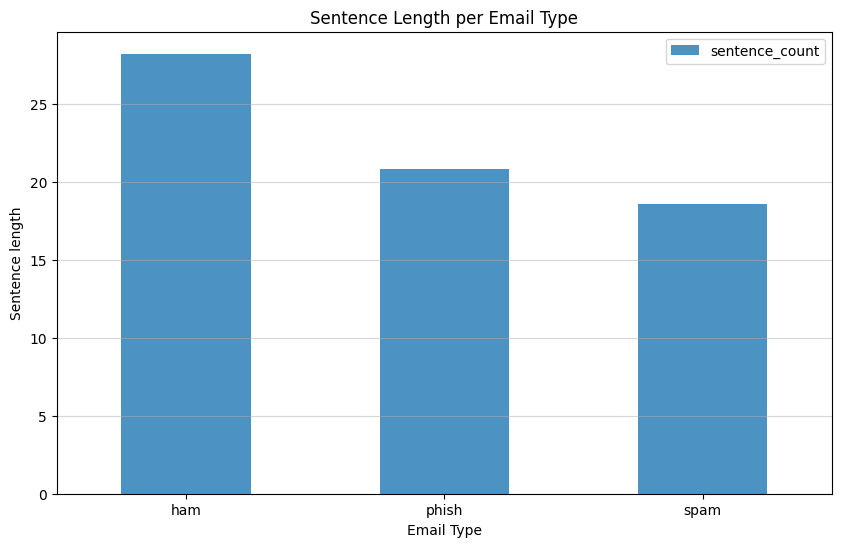

In [165]:
feature_cols = ["sentence_count"]
grouped = orig_email_df.groupby("Email Type")[feature_cols].mean()

grouped.plot(kind="bar", figsize=(10,6), alpha=0.8)
plt.title("Sentence Length per Email Type")
plt.xlabel("Email Type")
plt.ylabel("Sentence length")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.5)
plt.show()

## The Most Common Words for Each Category (After Cleaning)

In [166]:
stop_words = set(stopwords.words("english"))

def get_top_words_clean(texts, n=20):
    """Return top n most common words."""
    all_words = []
    for txt in texts:
        all_words.extend(txt.split()) 
    return Counter(all_words).most_common(n)

Initialize `top_words` and populate with top words if not already populated (process takes some time when initialized).

In [168]:
categories = balanced_df["Email Type"].unique().tolist()
top_words_clean = dict()

for category in categories:
    words = get_top_words_clean(balanced_df[balanced_df["Email Type"] == category]["Email Text"])
    top_words_clean[category] = words

pd.DataFrame(top_words_clean).head()

,ham,phish,spam
0,"(enron, 48292)","(â, 18809)","(e, 45165)"
1,"(ect, 28061)","(email, 17565)","(enron, 45040)"
2,"(language, 20573)","(company, 12514)","(ubs, 41552)"
3,"(would, 15971)","(u, 11215)","(message, 34402)"
4,"(please, 15795)","(free, 10835)","(please, 28258)"


### Remove Words that are Overrepresented
Some words do not appear to provide any additional value, like `enron` which is where the ham & spam emails are from. Let's remove them.

In [180]:
def remove_words(text, words_to_remove: list[str]):
    """Uses re.sub() to replace all occurrences of words to remove."""
    regex_pattern = r'\b(?:' + '|'.join(words_to_remove) + r')\b'
    return re.sub(regex_pattern, '', str(text), flags=re.IGNORECASE)

balanced_df["Email Text"] = balanced_df["Email Text"].apply(
    lambda x: remove_words(x, ["enron", "ubs", "etc", "ect", "e", "hou", "ivanhoe"])
)

for category in categories:
        words = get_top_words_clean(balanced_df[balanced_df["Email Type"] == category]["Email Text"])
        top_words_clean[category] = words

pd.DataFrame(top_words_clean).head()

,ham,phish,spam
0,"(language, 20573)","(â, 18809)","(message, 34402)"
1,"(would, 15971)","(email, 17565)","(please, 28258)"
2,"(please, 15795)","(company, 12514)","(subject, 27244)"
3,"(university, 15746)","(u, 11215)","(mail, 23734)"
4,"(com, 13792)","(free, 10835)","(schedule, 22250)"


Save updated data.

In [183]:
balanced_df.to_feather("./data/2_balanced_email_dataset.feather")

### Show Most Common Words Plots and Wordclouds

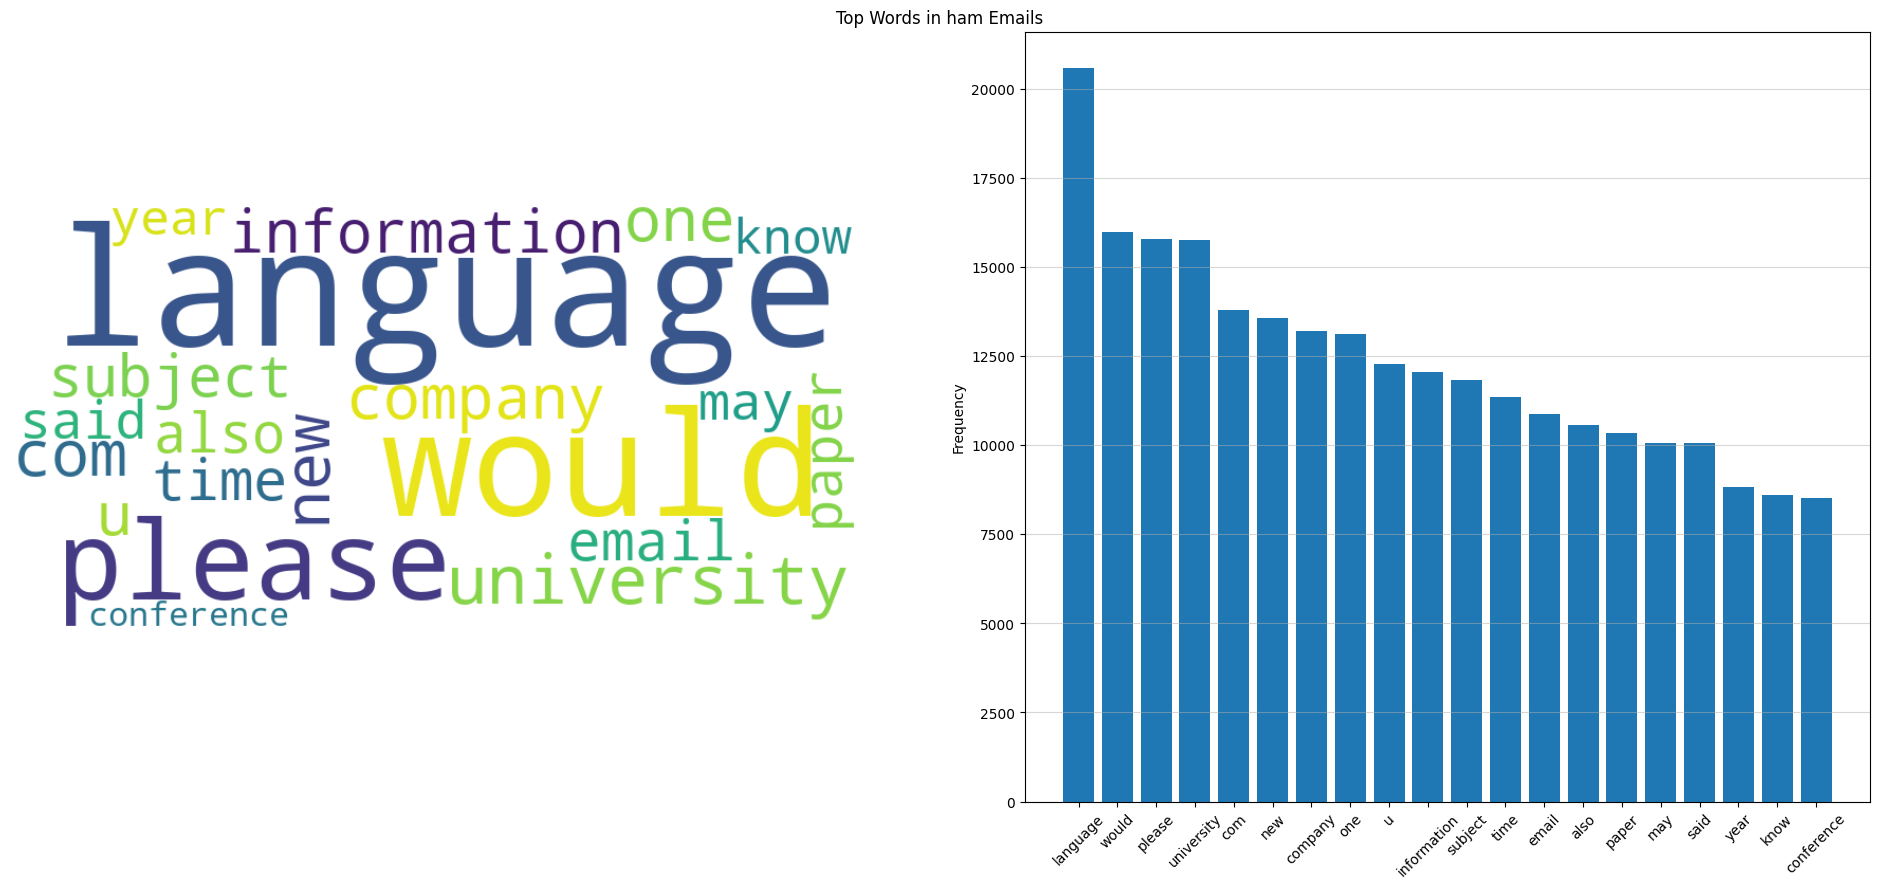

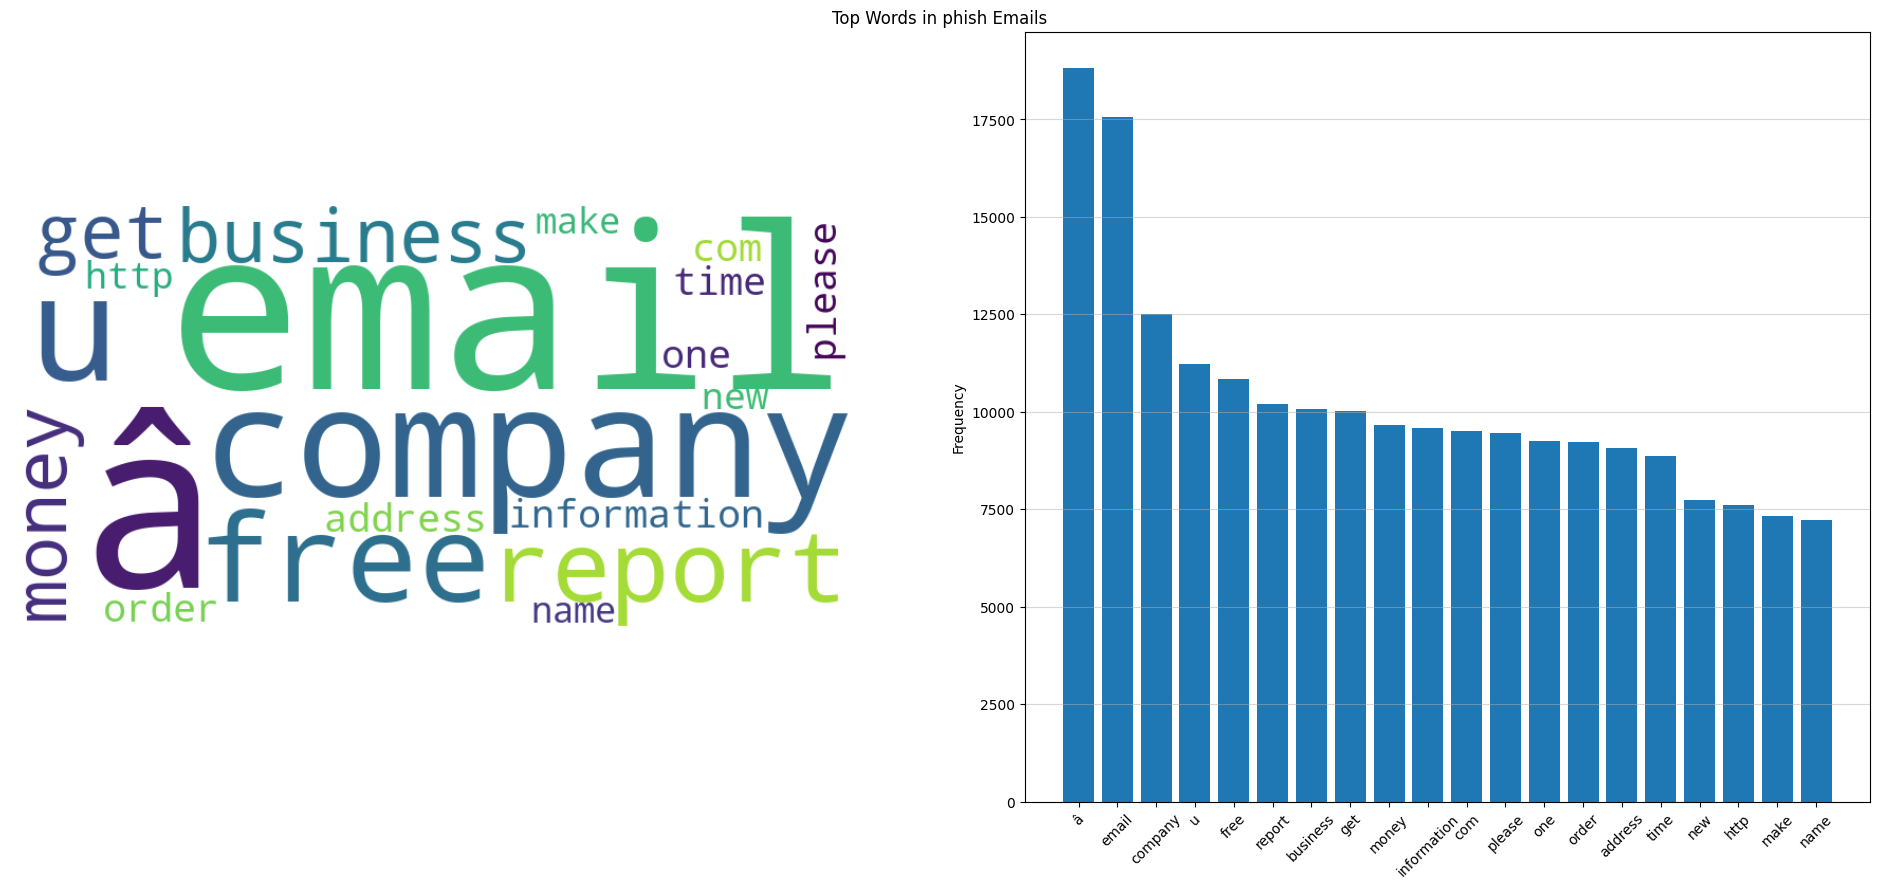

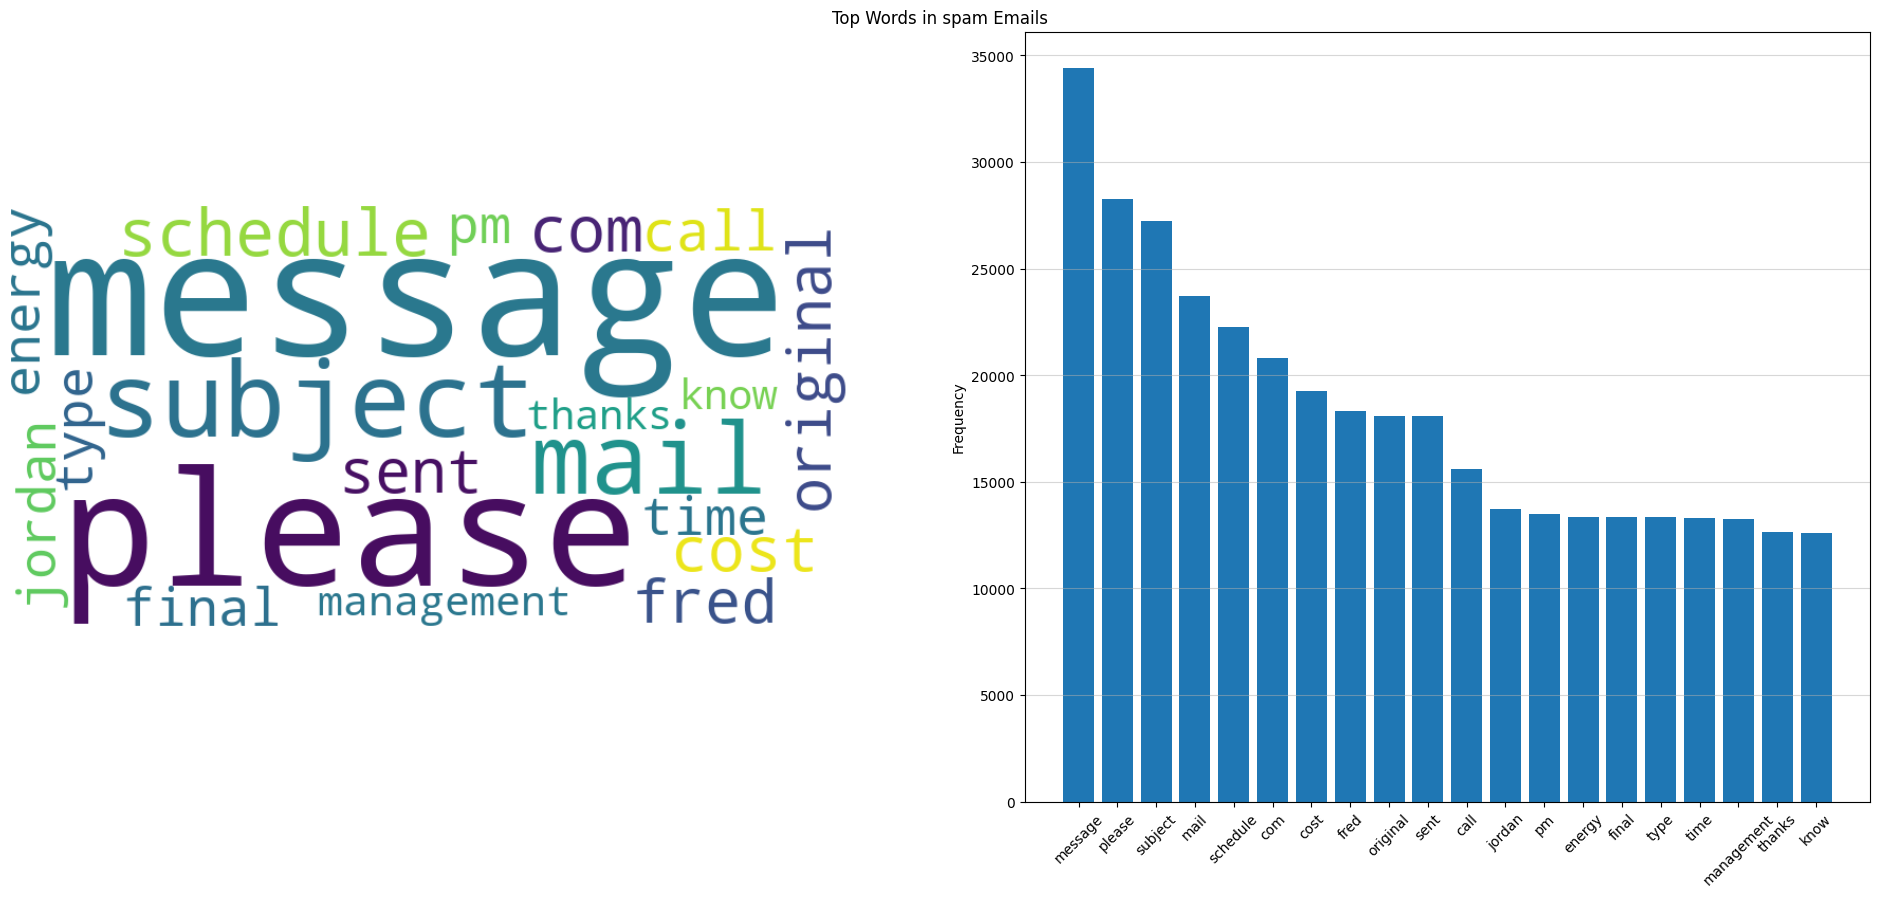

In [181]:
for category in categories:
    words, counts = zip(*top_words_clean[category])

    plt.figure(figsize=(24, 10), alpha=0.8)
    plt.title(f"Top Words in {category} Emails")
    plt.axis('off')

    wordcloud = WordCloud(
        width=800, height=400, background_color='white'
    ).generate_from_frequencies(dict(top_words_clean[category]))
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.5)
    plt.show()